<a href="https://colab.research.google.com/github/dzisandy/Deep-Learning/blob/master/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import warnings
warnings.simplefilter("ignore")

import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL.Image import open
from tqdm import trange
from IPython import display

In [2]:
'''http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html , downloaded from Google Drive, using Google Drive downloader'''
!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='0B7EVK8r0v71pZjFTYXZWM3FlRnM',dest_path='./data',unzip=True)


Unzipping...Done.


In [22]:
import os
import matplotlib.pyplot as plt
import numpy as np
# from scipy.misc import imresize
# root path depends on your computer
save_root = './celeba'
img_size = 64

if not os.path.isdir(save_root):
    os.mkdir(save_root)

transform = transforms.Compose([transforms.CenterCrop((178,178)),
                                transforms.Resize((img_size,img_size))
                               ])
                                
for i,item in enumerate(sorted(os.listdir(path='./img_align_celeba'))[0:21000]):
                                img = open(os.path.join('./img_align_celeba', item))
                                img = np.array(transform(img))
                                plt.imsave(fname=os.path.join(save_root, item), arr=img)

                                if (i % 1000) == 0:
                                    print('%d images complete' % i)

0 images complete
1000 images complete
2000 images complete
3000 images complete
4000 images complete
5000 images complete
6000 images complete
7000 images complete
8000 images complete
9000 images complete
10000 images complete
11000 images complete
12000 images complete
13000 images complete
14000 images complete
15000 images complete
16000 images complete
17000 images complete
18000 images complete
19000 images complete
20000 images complete


In [0]:
'''dataset generation'''
class CelebDataset(Dataset):
    def __init__(self, train = None, transform=None):
        super(Dataset, self).__init__()
        
        if train:
            self.img = sorted(os.listdir(path='./img_align_celeba'))[:20000]
        else:
            self.img = sorted(os.listdir(path='./img_align_celeba'))[20000:21000]
        self.transform = transform

    def __len__(self):
        return len(self.img)
    
    def __getitem__(self, idx):
        img = open(os.path.join('./img_align_celeba',self.img[idx]))        
        if self.transform:
            img = self.transform(img)
        return img

In [0]:
'''here we set the data size (now 128x128), and transformation to do it'''
img_size = 64
transform = transforms.Compose([transforms.CenterCrop((178,178)),
                                transforms.Resize((img_size,img_size)),
                                transforms.ToTensor()
                               ])

In [0]:
'''validation and train Dataloaders, batchsizes to be adjusted'''
t_batch_size = 64
v_batch_size = 5

train_dataset = CelebDataset(transform = transform, train = True)
train_loader = DataLoader(train_dataset,batch_size = t_batch_size, shuffle=True)

test_dataset = CelebDataset(transform = transform)
test_loader = DataLoader(test_dataset, batch_size = v_batch_size, shuffle=False)



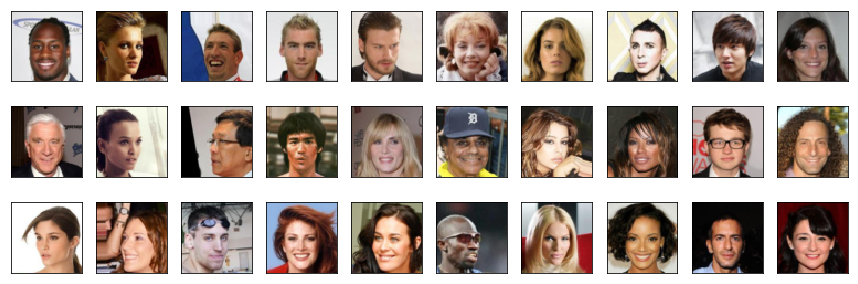

In [0]:
'''data visualization'''
for item in train_loader:
    plt.figure(figsize = (15,5))
    for i in range(30):
        plt.subplot(3,10,i+1)
        plt.imshow(transforms.ToPILImage()(item[i]))
        plt.xticks(())
        plt.yticks(())
    plt.show()
    break


In [0]:
class VAE(nn.Module):
    def __init__(self, training):
        super(VAE, self).__init__()
        
        
        self.training = training
        '''https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch'''
        def initialization(layer):
            if type(layer) == nn.Linear:
                torch.nn.init.xavier_uniform(layer.weight)
                layer.bias.data.fill_(0.)
          
        
    
#         self.nc = 3
#         self.ngf = 128
#         self.ndf = 128
#         self.latent_variable_size = 64
#         self.relu = 

#         self.conv_filt = 5
#         self.size = 4

        '''encoder'''
    
        self.conv = nn.Sequential()
        self.conv.add_module('conv1', nn.Conv2d(3, 128, 5, 2, 2))
        self.conv.add_module('bn1', nn.BatchNorm2d(128))
        self.conv.add_module('leakyrelu1', nn.LeakyReLU(0.2))
        
        self.conv.add_module('conv2', nn.Conv2d(128, 256, 5, 2, 2))
        self.conv.add_module('bn2', nn.BatchNorm2d(256))
        self.conv.add_module('leakyrelu2', nn.LeakyReLU(0.2))
        
        self.conv.add_module('conv3', nn.Conv2d(256, 512, 5, 2, 2))
        self.conv.add_module('bn3', nn.BatchNorm2d(512))
        self.conv.add_module('leakyrelu3', nn.LeakyReLU(0.2))
        
        self.conv.add_module('conv4', nn.Conv2d(512, 1024, 5, 2, 2))
        self.conv.add_module('bn4', nn.BatchNorm2d(1024))
        self.conv.add_module('leakyrelu4', nn.LeakyReLU(0.2))
        
        self.fc1 = nn.Linear(128*8*4*4, 64)
        self.fc2 = nn.Linear(128*8*4*4, 64)
        self.fc1.apply(initialization)
        self.fc2.apply(initialization)
        
        '''decoder'''
        
        self.fc3 = nn.Linear(64, 128*8*4*4)
        
        self.deconv1 = nn.Sequential()
        self.deconv1.add_module('deconv1', nn.ConvTranspose2d(1024, 512, 4, 2, 1))
        self.deconv1.add_module('bn5', nn.BatchNorm2d(512))
        self.deconv1.add_module('leakyrelu5', nn.LeakyReLU(0.2))
        
        self.deconv2 = nn.Sequential()
        self.deconv2.add_module('deconv2', nn.ConvTranspose2d(512, 256, 4, 2, 1))
        self.deconv2.add_module('bn6', nn.BatchNorm2d(256))
        self.deconv2.add_module('leakyrelu6', nn.LeakyReLU(0.2))
        
        
        self.deconv3 = nn.Sequential()

        self.deconv3.add_module('deconv3', nn.ConvTranspose2d(256, 128, 4, 2, 1))
        self.deconv3.add_module('bn7', nn.BatchNorm2d(128))
        self.deconv3.add_module('leakyrelu7', nn.LeakyReLU(0.2))
       
        self.deconv4 = nn.Sequential()

        self.deconv4.add_module('deconv3', nn.ConvTranspose2d(128, 3, 4, 2, 1))
        self.deconv4.add_module('sigmoid', nn.Sigmoid())
        
        
              
        
    def encode(self, x):        
        h = self.conv(x)
        h = h.view(-1, 128*8*4*4)

        return (self.fc1(h), self.fc2(h))
    
    def decode(self, x):
        h = self.fc3(x)
        h = h.view(-1, 1024, 4, 4)
        h1 = self.deconv1(h)
        h2 = self.deconv2(h1)
        h3 = self.deconv3(h2)
        h4 = self.deconv4(h3)
        return h4
        
        
    def reparametrize(self, mu, logvar):
        """ generates a normal distribution with the specified mean and std"""
        std = logvar.mul(0.5).exp_()    # converts log(var) to std
        std = torch.clamp(std, -50, 50)
        eps = Variable(torch.cuda.FloatTensor(std.size()).normal_())
        z = eps.mul(std).add_(mu)
        return(z)
    
        
    def forward(self, x):
        """ passes data through encode, reparameterization, and decode """
        mu, logvar = self.encode(x.view(-1, 3, 64, 64))
        z = self.reparametrize(mu, logvar)
        res = self.decode(z)
        return(mu, logvar)

In [0]:
from glob import glob
import os
import sys
import scandir
import time

import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from torch.autograd import Variable
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim.lr_scheduler import MultiStepLR
from torchvision.utils import save_image

from utils import load_data, load_mnist
from inception import InceptionV3
from fid_score import get_activations, calculate_frechet_distance

CHCKDIR = '/data/wae_checkpoints/'
CUDA = torch.cuda.is_available()
EPOCHS = 80

DATASET = 'celeb' # 'mnist' / 'celeb'
LOSS = 'wae-mmd'  # 'vae', 'wae-gan', 'wae-mmd'
MODE = 'train' # analyze or train

# data and loss-specific options
if DATASET == 'celeb':
    DIMS = 64            # image dimentions (assume square)
    N_Z = 64             # latent variable dimention
    N_CHAN = 3           # 3 = rgb, 1 = b&w
    N_DATA = 20000       # training set size
    N_TEST = 1000        # test set size
    BATCH = 64           # batch size
    SIGMA = 2            # sigma used for normal dist. sampling and MMD kernel

    if LOSS == 'vae':
        LAMBDA = None
        LR_VAE = 0.0001
        LR_DIS = None
        RECON = nn.BCELoss(size_average = False)
        SCALEBULLSHIT = 0.05 # a scaling factor on loss_recon (not in paper)

    elif LOSS == 'wae-gan':
        LAMBDA = 1
        LR_VAE = 0.0003
        LR_DIS = 0.001
        RECON = nn.MSELoss(size_average = False)
        SCALEBULLSHIT = 0.05 # a scaling factor on loss_recon (not in paper)

    elif LOSS == 'wae-mmd':
        LAMBDA = 10        # scaling factor on the WAE penalty !!!! changed for stability? !!!
        LR_VAE = 0.00001   # !!!changed for stability from orig paper!!!
        LR_DIS = None      # Learning rate on discriminator (for wae-gan)
        RECON = nn.MSELoss(size_average = False)
        SCALEBULLSHIT = 1 # a scaling factor on loss_recon (not in paper)

    DATADIR = './celeba/data/'

    im_data = load_data('celeba_data.npy', N_DATA, DATADIR, BATCH, (N_CHAN, DIMS))
    im_test = load_data('celeba_test.npy', N_TEST, DATADIR, BATCH, (N_CHAN, DIMS))

elif DATASET == 'mnist':
    DIMS = 28
    N_Z = 8
    N_CHAN = 1
    N_DATA = -1
    N_TEST = -1
    BATCH = 100
    LAMBDA = 10

    if LOSS == 'vae':
        SIGMA = 1
        LR_VAE = 0.001
        SCALEBULLSHIT = 1
        RECON = nn.BCELoss(size_average = False)
        LR_DIS = None

    elif LOSS == 'wae-gan':
        SIGMA = 2
        LR_VAE = 0.001
        SCALEBULLSHIT = 1
        RECON = nn.MSELoss(size_average = False)
        LR_DIS = 0.0005

    elif LOSS == 'wae-mmd':
        SIGMA = 2
        LR_VAE = 0.00001
        SCALEBULLSHIT = 1
        RECON = nn.MSELoss(size_average = False)
        LR_DIS = None


    im_data, im_test = load_mnist(batch_size=BATCH)


class VAE(nn.Module):
    def __init__(self, nc, ngf, ndf, latent_variable_size):
        super(VAE, self).__init__()

        self.nc = nc
        self.ngf = ngf
        self.ndf = ndf
        self.latent_variable_size = latent_variable_size
        self.relu = nn.LeakyReLU(0.2)

        if DATASET == 'celeb':
            self.conv_filt = 5
            self.size = 4
        elif DATASET == 'mnist':
            self.conv_filt = 4
            self.size = 3

        # encoder
        self.e1 = nn.Sequential(nn.Conv2d(nc, ndf, self.conv_filt, 2, 2),
            nn.BatchNorm2d(ndf), self.relu)
        self.e2 = nn.Sequential(nn.Conv2d(ndf, ndf*2, self.conv_filt, 2, 2),
            nn.BatchNorm2d(ndf*2), self.relu)
        self.e3 = nn.Sequential(nn.Conv2d(ndf*2, ndf*4, self.conv_filt, 2, 2),
            nn.BatchNorm2d(ndf*4), self.relu)
        self.e4 = nn.Sequential(nn.Conv2d(ndf*4, ndf*8, self.conv_filt, 2, 2),
            nn.BatchNorm2d(ndf*8), self.relu)

        self.fc1 = nn.Linear(ndf*8*self.size*self.size, latent_variable_size)
        self.fc2 = nn.Linear(ndf*8*self.size*self.size, latent_variable_size)

        # decoder
        self.d1 = nn.Linear(latent_variable_size, ngf*8*self.size*self.size)
        self.d2 = nn.Sequential(nn.ConvTranspose2d(ngf*8, ngf*4, self.conv_filt-1, 2, 1),
            nn.BatchNorm2d(ngf*4, 1.e-3), self.relu)

        if DATASET == 'celeb':
            self.d3 = nn.Sequential(nn.ConvTranspose2d(ngf*4, ngf*2, self.conv_filt-1, 2, 1),
                nn.BatchNorm2d(ngf*2, 1.e-3), self.relu)
            self.d4 = nn.Sequential(nn.ConvTranspose2d(ngf*2, ngf, self.conv_filt-1, 2, 1),
                nn.BatchNorm2d(ngf, 1.e-3), self.relu)
            self.d5 = nn.Sequential(nn.ConvTranspose2d(ngf, nc, self.conv_filt-1, 2, 1),
                nn.Sigmoid())

        elif DATASET == 'mnist':
            self.d3 = nn.Sequential(nn.ConvTranspose2d(ngf*4, ngf*2, self.conv_filt-2, 2, 1),
                nn.BatchNorm2d(ngf*2, 1.e-3), self.relu)
            self.d4 = nn.Sequential(nn.ConvTranspose2d(ngf*2, ngf, self.conv_filt-1, 2, 1),
                nn.BatchNorm2d(ngf, 1.e-3), self.relu)
            self.d5 = nn.Sequential(nn.ConvTranspose2d(ngf, nc, self.conv_filt-2, 2, 1),
                    nn.Sigmoid())

    def encoder(self, x):
        """ encoder architecture: note 2 read-out heads for mu and logvar """
        h1 = self.e1(x)
        h2 = self.e2(h1)
        h3 = self.e3(h2)
        h4 = self.e4(h3)
        h4 = h4.view(-1, self.ndf*8*self.size*self.size)

        return(self.fc1(h4), self.fc2(h4))

    def reparametrize(self, mu, logvar):
        """ generates a normal distribution with the specified mean and std"""
        std = logvar.mul(0.5).exp_()    # converts log(var) to std

        # with MDD, standard deviation blows up to produce NaNs without tiny
        # learning rates, so clamp std to prevent z_encoded from naning out
        std = torch.clamp(std, -50, 50)

        #print('mu={}, std={}'.format(torch.max(mu).data[0], torch.max(std).data[0]))

        # z is a gaussian with std and mean=mu. begin with eps (a stock gauss)
        if CUDA:
            eps = Variable(torch.cuda.FloatTensor(std.size()).normal_())
        else:
            eps = Variable(torch.FloatTensor(std.size()).normal_())

        z = eps.mul(std).add_(mu)

        return(z)

    def decoder(self, z):
        """ decoder architecture """
        h1 = self.d1(z)
        h1 = h1.view(-1, self.ngf*8, self.size, self.size)
        h2 = self.d2(h1)
        h3 = self.d3(h2)
        h4 = self.d4(h3)
        h5 = self.d5(h4)

        return(self.d5(h4))

    def encode(self, x):
        """ feeds data through encoder and reparameterization to produce z """
        mu, logvar = self.encoder(x.view(-1, self.nc, DIMS, DIMS))
        z = self.reparametrize(mu, logvar)
        return(z)

    def decode(self, z):
        """ feeds z through decoder """
        return(self.decoder(z))

    def sample_pz(self, n):
        """
        samples noise from a gaussian distribution with mean=0 and experiment-
        specific standard-deviation (SIGMA)
        """
        return(Variable(torch.normal(torch.zeros(n, N_Z), std=SIGMA).cuda()))

    def forward(self, x):
        """ passes data through encode, reparameterization, and decode """
        mu, logvar = self.encoder(x.view(-1, self.nc, DIMS, DIMS))
        z = self.reparametrize(mu, logvar)
        res = self.decoder(z)
        return(res, mu, logvar)


class Discriminator(nn.Module):
    def __init__(self, latent_variable_size):
        super(Discriminator, self).__init__()

        self.latent_variable_size = latent_variable_size
        self.hid_size = 512

        # 3 hidden-layer discriminator
        self.linear = nn.Sequential(
            nn.Linear(self.latent_variable_size, self.hid_size), nn.ReLU(),
            nn.Linear(self.hid_size, self.hid_size), nn.ReLU(),
            nn.Linear(self.hid_size, self.hid_size), nn.ReLU(),
            nn.Linear(self.hid_size, self.hid_size), nn.ReLU(),
            nn.Linear(self.hid_size, 2)
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data.normal_(0.0, 0.0099999)
                m.bias.data.zero_()

    def forward(self, z):
        return(self.linear(z))

## TODO: move this somewhere else (models should go in models.py)
# instantiate models
vae = VAE(nc=N_CHAN, ngf=128, ndf=128, latent_variable_size=N_Z)
dis = Discriminator(N_Z)

if CUDA:
    vae = vae.cuda()
    dis = dis.cuda()

if DATASET == 'celeb':
    inc = InceptionV3([3])

    if CUDA:
        inc = inc.cuda()

# instantiate optimizers
opt_vae = torch.optim.Adam(vae.parameters(), lr=LR_VAE, betas=(0.5, 0.999))
opt_dis = torch.optim.Adam(dis.parameters(), lr=LR_DIS, betas=(0.5, 0.999))

# learning rate schedulers
sch_1_vae = MultiStepLR(opt_vae, milestones=[30], gamma=0.5)
sch_2_vae = MultiStepLR(opt_vae, milestones=[50], gamma=0.2)

if LOSS == 'wae-gan':
    sch_1_dis = MultiStepLR(opt_dis, milestones=[30], gamma=0.5)
    sch_2_dis = MultiStepLR(opt_dis, milestones=[50], gamma=0.2)


def isnan(x):
    return(x != x)


def calc_blur(X):
    """
    https://github.com/tolstikhin/wae/blob/master/wae.py -- line 344
    Keep track of the min blurriness / batch for each test loop
    """
    # RGB case -- convert to greyscale
    if X.size(1) == 3:
        X = torch.mean(X, 1, keepdim=True)

    lap_filter = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    lap_filter = lap_filter.reshape([1, 1, 3, 3])
    lap_filter = Variable(torch.from_numpy(lap_filter).float())

    if CUDA:
        lap_filter = lap_filter.cuda()

    # valid padding (i.e., no padding)
    conv = F.conv2d(X, lap_filter, padding=0, stride=1)

    # smoothness is the variance of the convolved image
    var = torch.var(conv)

    return(var)


def ae_loss(recon_x, X):
    # we do this so we can swap in different reconstruction terms
    return(RECON(recon_x, X))


def kld_loss(mu, logvar):
    """
    https://arxiv.org/abs/1312.6114 (Appendix B)
    """
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return(kld)


def wae_gan_loss(z_encoded, z_sample):
    """
    https://github.com/wsnedy/WAE_Pytorch/blob/master/wae_for_mnist.py
    https://myurasov.github.io/2017/09/24/wasserstein-gan-keras.html
    """
    # cross entropy loss, as discriminator has 2 outputs to distinguish real
    # (pz) and fake (qz) samples.
    ce = nn.CrossEntropyLoss()

    logits_pz = dis(z_encoded) # is 0 when correct
    logits_qz = dis(z_sample)  # is 1 when correct

    # this is used in the WAE loss function, i.e., when is pz 1?
    # we use [:, 1] to make our targets (ones_like or zeros_like) a single col
    loss_penalty = ce(logits_pz, torch.ones_like(logits_pz[:, 1]).long())

    # this is used to train the Discriminator
    loss_pz = ce(logits_pz, torch.zeros_like(logits_pz[:, 1]).long())
    loss_qz = ce(logits_qz, torch.ones_like(logits_qz[:, 1]).long())
    loss_discrim = LAMBDA * (loss_pz + loss_qz)

    return (loss_discrim, logits_pz, logits_qz), loss_penalty


def wae_mmd_loss(x, y):
    """
    inverse multiquadratic kernel for MMD
    C = 2.0 * N_Z * (sigma ** 2)
    return(C / (C + torch.mean(z_pair[0] - z_pair[1]) ** 2))
    https://github.com/tolstikhin/wae/blob/master/wae.py -- line 226
    https://discuss.pytorch.org/t/maximum-mean-discrepancy-mmd-and-radial-basis-function-rbf/1875
    https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/
    """
    # x = z_encoded # y = z_sampled
    norm_x = torch.sum(x**2, 1, keepdim=True)
    norm_y = torch.sum(y**2, 1, keepdim=True)

    dot_xx = torch.mm(x, x.t())
    dot_yy = torch.mm(y, y.t())
    dot_xy = torch.mm(x, y.t())

    dist_xx = norm_x + norm_x.transpose(1, 0) - 2.0 * dot_xx
    dist_yy = norm_y + norm_y.transpose(1, 0) - 2.0 * dot_yy
    dist_xy = norm_y + norm_x.transpose(1, 0) - 2.0 * dot_xy

    # kernel: k(x, y) = C / (C + ||x - y||^2)
    # expand: xx + yy - 2xy
    C_init = 2.0 * N_Z * (SIGMA ** 2)

    mmd = 0.0

    for scale in [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]:
        C = C_init * scale

        res_xx = (C / (C + dist_xx + 1e-8))
        dims = res_xx.size(0)
        mask = Variable(torch.abs(1.0-torch.eye(dims)).cuda())
        res_xx = torch.mul(res_xx, mask)
        res_xx = 1.0 * torch.sum(res_xx) / (BATCH*(BATCH-1))     # no diag

        res_yy = (C / (C + dist_yy + 1e-8))
        dims = res_yy.size(0)
        mask = Variable(torch.abs(1.0-torch.eye(dims)).cuda())
        res_yy = torch.mul(res_yy, mask)
        res_yy = 1.0 * torch.sum(res_yy) / (BATCH*(BATCH-1))     # no diag

        res_xy = C / (C + dist_xy + 1e-8)
        res_xy = 2.0 * torch.sum(res_xy) / BATCH**2              # keep diag

        mmd += (res_xx + res_yy - res_xy)

    if isnan(mmd.data[0]):
        import IPython; IPython.embed()

    # mmd occasionally grows very large and causes the weights to explode, so
    # we clamp it what what are we think are 'large' values (not in paper or
    # original source code).
    mmd = torch.clamp(mmd, -5, 5)

    return(mmd)


def traverse_latent(images1, images2):
    """
    Accepts two equally-sized minibatches, outputs latent-space traversal img.
    """

    z1 = vae.encode(images1)
    z2 = vae.encode(images2)

    alphas = [0, 0.1, 0.2, 0.3, 0.4, 0.5 , 0.6, 0.7, 0.8, 0.9, 1.0] # num_images goes here
    results = None

    for alpha in alphas:
        z = alpha*z1 + (1-alpha)*z2

        recon_x = vae.decode(z)

        if type(results) == type(None):
            results = recon_x.data
        else:
            results = torch.cat((results, recon_x.data), dim=0)

    save_image(results, 'img/{}_{}_interpolation.jpg'.format(DATASET, LOSS),
        nrow=10, padding=2)


def calc_loss(X, recon, mu, logvar, method='vae', verbose=False):
    """
    key observation: do we SUBTRACT or ADD LAMBDA*PENALTY/MMD?
    in the paper he always adds LAMBDA*PENALTY/MMD...
    """

    try:
        assert method in ['vae', 'wae-gan', 'wae-mmd']
    except:
        print('incorrect LOSS specified: {}'.format(method))
        sys.exit(1)

    loss_gan = None # default value, if not using wae-gan

    loss_recon = ae_loss(recon, X)

    if method == 'vae':
        kld = kld_loss(mu, logvar)
        loss = loss_recon + kld

        if verbose:
            print('mu: {}, logvar: {}'.format(torch.max(mu).data[0], torch.max(logvar).data[0]))
            print('recon: {}, kld: {}'.format(loss_recon.data[0], kld.data[0]))

    elif method == 'wae-gan':
        z_encoded = vae.encode(X)
        z_sampled = vae.sample_pz(X.size(0)) # always normal distribution
        loss_gan, loss_penalty = wae_gan_loss(z_encoded, z_sampled)

        # normalize loss for discriminator by LAMBDA/BATCH
        loss_recon = loss_recon * SCALEBULLSHIT
        loss_gan = LAMBDA * loss_gan[0] / BATCH
        loss = loss_recon + (LAMBDA * loss_penalty)

        # loss_penalty is the misclassification rate os z_encoded by discrim
        if verbose:
            print('z_encoded {} : {} : {}'.format(
                torch.min(z_encoded).data[0],
                torch.mean(z_encoded).data[0],
                torch.max(z_encoded).data[0]))
            print('recon: {}, penalty: {}, disc: {}'.format(
                loss_recon.data[0], loss_penalty.data[0], loss_gan.data[0]))

    elif method == 'wae-mmd':
        z_encoded = vae.encode(X)
        z_sampled = vae.sample_pz(X.size(0)) # always normal distribution
        loss_mmd = wae_mmd_loss(z_encoded, z_sampled)

        # loss_mmd is already normalized by BATCH**2, see wae_mmd_loss
        loss_recon = loss_recon * SCALEBULLSHIT
        loss = loss_recon + (LAMBDA * loss_mmd)

        if verbose:
            print('z_encoded {} : {} : {}'.format(
                torch.min(z_encoded).data[0],
                torch.mean(z_encoded).data[0],
                torch.max(z_encoded).data[0]))
            print('recon: {}, mmd: {}'.format(loss_recon.data[0], loss_mmd.data[0]))

    return(loss, loss_gan)


def train(ep, data):
    vae.train()
    train_loss = 0

    batch_num = 0
    for batch, X in enumerate(data):

        if CUDA:
            X = X.cuda()
        X = Variable(X)

        # inserts single channel dimensions for black and white images
        if DATASET == 'mnist':
            X = X.unsqueeze(1)

        recon, mu, logvar = vae.forward(X)

        loss, loss_gan = calc_loss(X, recon, mu, logvar, method=LOSS)

        # optimize VAE / WAE
        opt_vae.zero_grad()
        loss.backward(retain_graph=True)
        opt_vae.step()
        train_loss += loss.data[0]

        if LOSS == 'wae-gan':
            # optimize discriminator
            opt_dis.zero_grad()
            loss_dis = loss_gan[0]
            loss_dis.backward()
            opt_dis.step()

        batch_num += 1
        if batch % 100 == 0:
            print('[ep={}/batch={}]: loss={:.4f}'.format(
                ep, batch, train_loss / batch_num))

    return(train_loss / len(data))


def test(ep, data):
    vae.eval()
    test_loss = 0

    for batch, X in enumerate(data):

        if CUDA:
            X = X.cuda()
        X = Variable(X)

        # inserts single channel dimensions for black and white images
        if DATASET == 'mnist':
            X = X.unsqueeze(1)

        recon, mu, logvar = vae(X)
        loss, loss_gan = calc_loss(X, recon, mu, logvar, method=LOSS)
        test_loss += loss.data[0]

        # convolution of data with a laplacian filter
        blur = calc_blur(recon)

        # inception distance only works on celeb data set (requires 64x64)
        fid = 0 # default value for mnist
        if DATASET == 'celeb':
            X_act = get_activations(X.cpu().data.numpy(), inc,
                batch_size=BATCH, dims=DIMS, cuda=CUDA)
            recon_act = get_activations(recon.cpu().data.numpy(), inc,
                batch_size=BATCH, dims=DIMS, cuda=CUDA)

            X_act_mu = np.mean(X_act, axis=0)
            recon_act_mu = np.mean(recon_act, axis=0)
            X_act_sigma = np.cov(X_act, rowvar=False)
            recon_act_sigma = np.cov(recon_act, rowvar=False)

            fid = calculate_frechet_distance(X_act_mu, X_act_sigma, recon_act_mu,
                recon_act_sigma, eps=1e-6)

        save_image(X.data, 'img/{}_{}_ep_{}_data.jpg'.format(DATASET, LOSS, ep), nrow=8, padding=2)
        save_image(recon.data, 'img/{}_{}_ep_{}_recon.jpg'.format(DATASET, LOSS, ep), nrow=8, padding=2)

    test_loss = test_loss / len(data)
    print('[{}] test loss: {:.4f}'.format(ep, test_loss))

    return(test_loss, blur.data[0], fid)


def analyze():

    checkpoints = glob(os.path.join(CHCKDIR, '{}_{}_*'.format(DATASET, LOSS)))
    checkpoints.sort()
    checkpoint = checkpoints[-1]

    inc = InceptionV3([3])
    inc = inc.cuda()

    vae = VAE(nc=N_CHAN, ngf=128, ndf=128, latent_variable_size=N_Z)
    vae.load_state_dict(torch.load(checkpoint))
    vae.cuda()

    n_samples = 1
    traverse_latent(Variable(im_test.dataset[:n_samples, :, :, :]).cuda(),
        Variable(im_test.dataset[n_samples:n_samples*2, :, :, :]).cuda())


def main():

    f = open('{}_{}_stats.csv'.format(DATASET, LOSS), 'w')
    f.write('epoch,loss,blur,fid\n')

    for ep in range(EPOCHS):

        # decay learning rates
        sch_1_vae.step()
        sch_2_vae.step()

        if LOSS == 'wae-gan':
            sch_1_dis.step()
            sch_2_dis.step()

        train_loss = train(ep, im_data)
        test_loss, blur, fid = test(ep,  im_test)

        f.write('{},{},{},{}\n'.format(ep, test_loss, blur, fid))

        print('{}: {} LOSS = {}/{}'.format(DATASET, LOSS, train_loss, test_loss))

        if ep+1 % 10 == 0:
            torch.save(vae.state_dict(), os.path.join(CHCKDIR,
                '{}_{}_ep_{}_train_loss_{:.4f}_test_loss_{:.4f}.pth'.format(
                DATASET, LOSS, ep, train_loss, test_loss)))

    f.close()

if __name__ == '__main__':
    if MODE == 'train':
        main()
    elif MODE == 'analyze':
        analyze()
